# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [2]:
np.random.seed(9001)
df = pd.read_csv('hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
data_train.describe()

,Biomarker 1,Biomarker 2,Diagnosis
count,102.000000,102.000000,102.000000
mean,0.344213,0.136095,1.392157
std,0.830087,2.201512,0.677164
min,-2.302485,-11.512925,1.000000
25%,-0.105349,-1.076236,1.000000
50%,0.222351,0.641859,1.000000
75%,0.470010,1.273894,2.000000
max,4.032469,3.970292,3.000000


## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

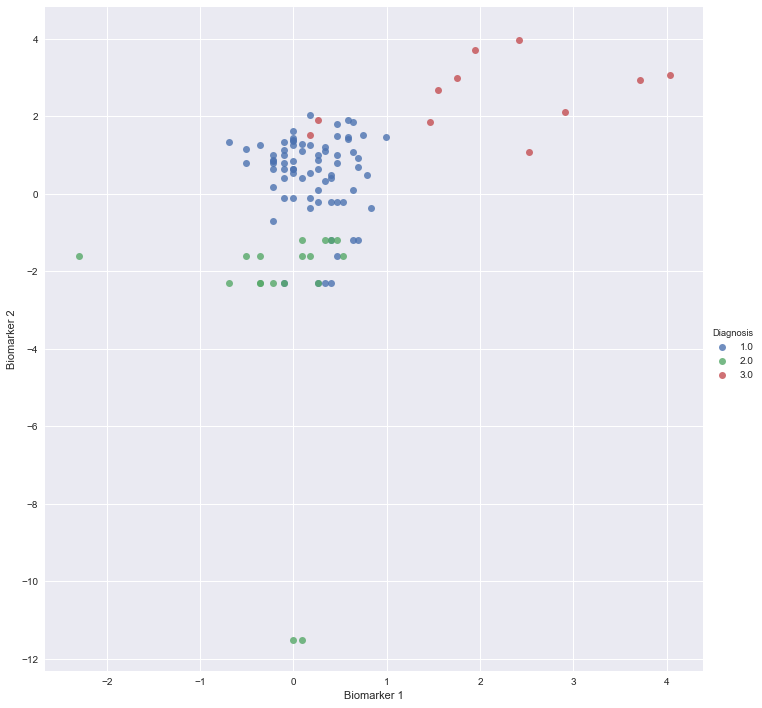

In [4]:
import seaborn as sns
sns.lmplot(x='Biomarker 1',y='Biomarker 2',data = data_train,hue='Diagnosis',fit_reg=False,size = 10)

In [5]:
# train and test x and y
X_train = data_train.iloc[:,0:2]
y_train = data_train.iloc[:,2]
X_test = data_test.iloc[:,0:2]
y_test = data_test.iloc[:,2]
# I define my regularization parameters here for logistic
reg_params = 10


In [6]:
reg_params


10

In [7]:
# parameters and models for multiclass reg (ovr and multinomial)
lrcv_ovr = LogisticRegressionCV(fit_intercept = True,multi_class ='ovr',penalty = 'l2',Cs = reg_params)
lrcv_ovr.fit(X_train,y_train)

lrcv_multi = LogisticRegressionCV(fit_intercept = True,multi_class ='multinomial',penalty = 'l2',Cs = reg_params)
lrcv_multi.fit(X_train,y_train)

# lda
svd = LinearDiscriminantAnalysis(solver='svd')
svd.fit(X_train,y_train)

# qda
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train,y_train)

# optimized knn
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':[1,2,3,4,5,6,10,20,50]}
knngs = GridSearchCV(KNeighborsClassifier(),param_grid)
knngs.fit(X_train,y_train)
print(knngs.best_estimator_)
# found using print statement above

knn = KNeighborsClassifier(leaf_size=30,metric='minkowski',p=2,n_neighbors=3)
knn.fit(X_train,y_train)

#multi class with quad terms
xtr = pd.DataFrame.copy(X_train)
xtst = pd.DataFrame.copy(X_test)
polfeat = PolynomialFeatures(2,include_bias=False)
xtr = polfeat.fit_transform(xtr)
xtst = polfeat.fit_transform(xtst)
lrcv_pol = LogisticRegressionCV(fit_intercept = True,multi_class ='multinomial',penalty = 'l2',Cs = reg_params)
lrcv_pol = lrcv_pol.fit(xtr,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


In [8]:
# start a results table
train_acc = pd.DataFrame(np.c_[lrcv_ovr.score(X_train,y_train),lrcv_multi.score(X_train,y_train),svd.score(X_train,y_train),qda.score(X_train,y_train),knn.score(X_train,y_train),lrcv_pol.score(xtr,y_train)],columns = ['Log (OvR)','Log (Multi)','LDA','QDA','KNN','Log+pol(multi)'])
test_acc = pd.DataFrame(np.c_[lrcv_ovr.score(X_test,y_test),lrcv_multi.score(X_test,y_test),svd.score(X_test,y_test),qda.score(X_test,y_test),knn.score(X_test,y_test),lrcv_pol.score(xtst,y_test)],columns = ['Log (OvR)','Log (Multi)','LDA','QDA','KNN','Log+pol(multi)'])
dfmix = pd.concat([train_acc,test_acc],axis=0)

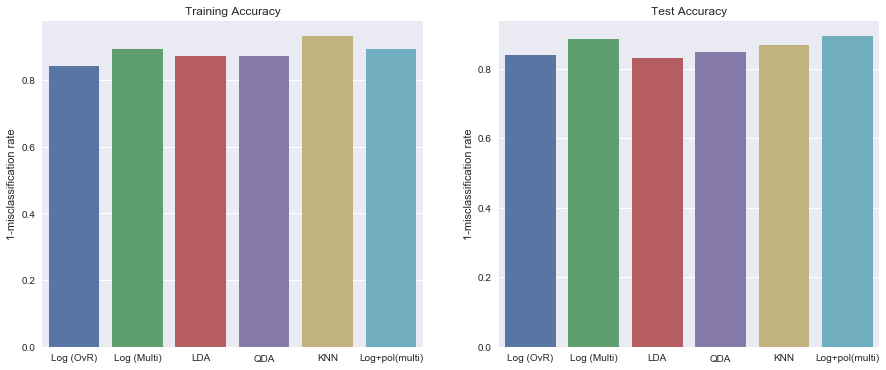

In [9]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
sns.barplot(data=train_acc,ax=ax[0])
ax[0].set_title('Training Accuracy')
ax[0].set_ylabel('1-misclassification rate')
sns.barplot(data=test_acc,ax=ax[1])
ax[1].set_title('Test Accuracy')
ax[1].set_ylabel('1-misclassification rate')

In [10]:
dfmix.index =['Training Accuracy:','Testing Accuracy:']


### Your Answer Here

**Question- 
Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?
**



- It seems possible that the data points can be split using a linear model since there are three regions that can be divided up using 2 lines with some level of misclassification. It does appear that the normal patients are clustered in the center in a circular pattern suggesting that a non-linear model may do mildly better.


**Question-
Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).
**



- In ovr logreg we train K (3 in our case) different models in which we determine coefficients for each model by converting the response variable into a binary set of class i (1) and not class i (0). In multinomial, we train K-1 (K=3, -> 2 models) where we determine coefficients by computing the log odds of being in class i divided by class j(reference class). So multinomial has 1 fewer model and compares one class to $\textbf{every}$ other whereas in ovr the comparison is between one class and $\textbf{all}$ others clustered together.


**Question-
Fit linear classification models on the thyroid data set using both the methods. You should use  L2L2  regularization in both cases, tuning the regularization parameter using cross-validation. Is there a difference in the overall classification accuracy of the two methods on the training and test sets?
Also, compare the training and test accuracies of these models with the following classification methods:
Multiclass Logistic Regression with quadratic terms
Linear Discriminant Analysis
Quadratic Discriminant Analysis
k-Nearest Neighbors 
**







- I list out the performance metrics on train test in this table below:

In [11]:
dfmix

,Log (OvR),Log (Multi),LDA,QDA,KNN,Log+pol(multi)
Training Accuracy:,0.843137,0.892157,0.872549,0.872549,0.931373,0.892157
Testing Accuracy:,0.840708,0.884956,0.831858,0.849558,0.867257,0.893805


- We find that **multinomial** regression performs slightly better in both the training and test set in comparison to **OvR** as can be seen in the first two columns. This marked difference may be precisely due to the fact that multinomial regression unlike OvR doesn't cluster classes (1 through i as not in class i+1) to determine class i+1. 
- **LDA and QDA** both perform with the same training accuracy as linear logistic (OvR) yet their test scores are much lower than that of logistic(OvR). This is somewhat expected since not all our classes appear to be normally distributed w.r.t our biomarkers. 
- Optimized **KNN** has a much higher training score than all the other models but its test score is not better than either linear logistic OvR or Multinomial. This may be due to the fact that there is some over fitting going on. KNN does perform better than LDA/QDA in the test set indicating that those two methods may not be the best for this particular classification task.
- **Polynomial Logistic Regression (OvR)** performs the best of all the models we have. This can be expected since adding complexity through non-linear terms allows for non linear classification boundaries which would be ideal in this situation.


**Question -
Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN.
Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms?
**

- As we can see above, the addition of non-linear terms increases the test accuracy. It is clear from the figure we initially plotted that the classification boundaries could benefit from being non linear and this is precisely what we are seeing in the results. This model may be performing slightly better than the linear model since the 'normal' patients are clustered in a circle at the centre which is a non-linear boundary.



## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [12]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias=False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.3)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='green', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

### Training Set Boundaries

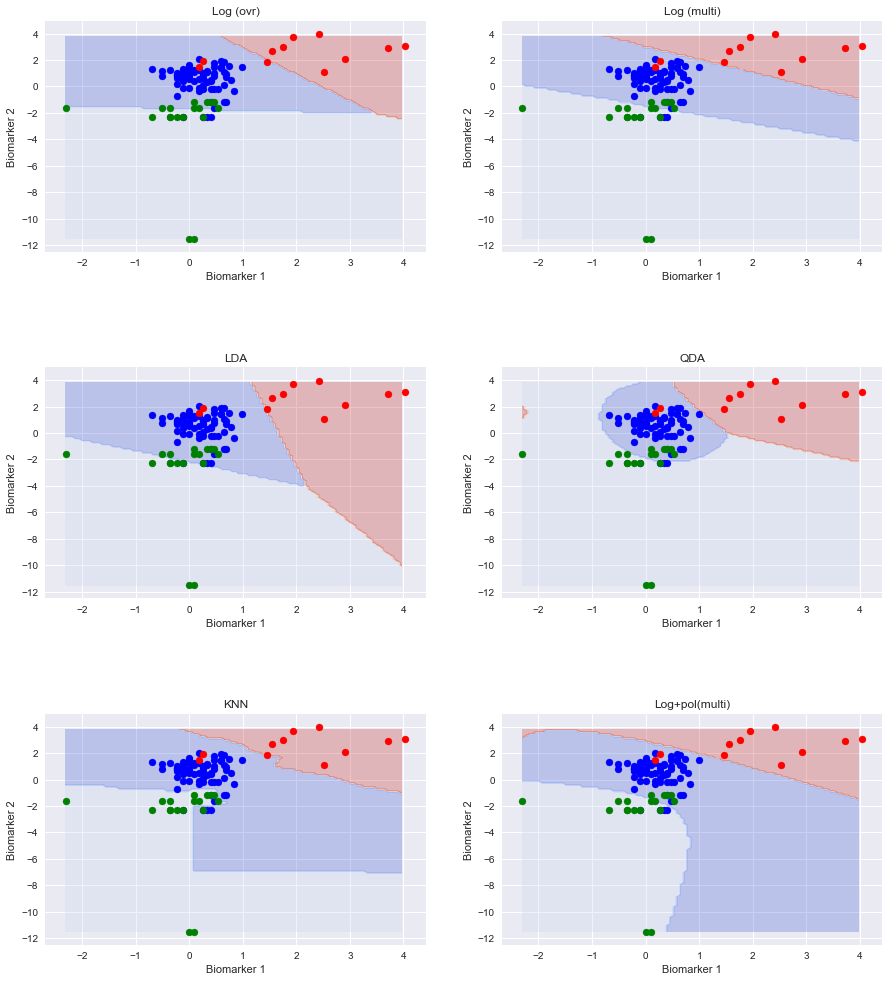

In [13]:
fig,ax = plt.subplots(3,2,figsize=(15,17))
plot_decision_boundary(X_train.as_matrix(),y_train.values,lrcv_ovr,'Log (ovr)',ax[0,0])
plot_decision_boundary(X_train.as_matrix(),y_train.values,lrcv_multi,'Log (multi)',ax[0,1])
plot_decision_boundary(X_train.as_matrix(),y_train.values,svd,'LDA',ax[1,0])
plot_decision_boundary(X_train.as_matrix(),y_train.values,qda,'QDA',ax[1,1])
plot_decision_boundary(X_train.as_matrix(),y_train.values,knn,'KNN',ax[2,0])
plot_decision_boundary(xtr,y_train.values,lrcv_pol,'Log+pol(multi)', ax[2,1],poly_degree =2)
fig.subplots_adjust(hspace=.5)

### Testing Set Boundaries

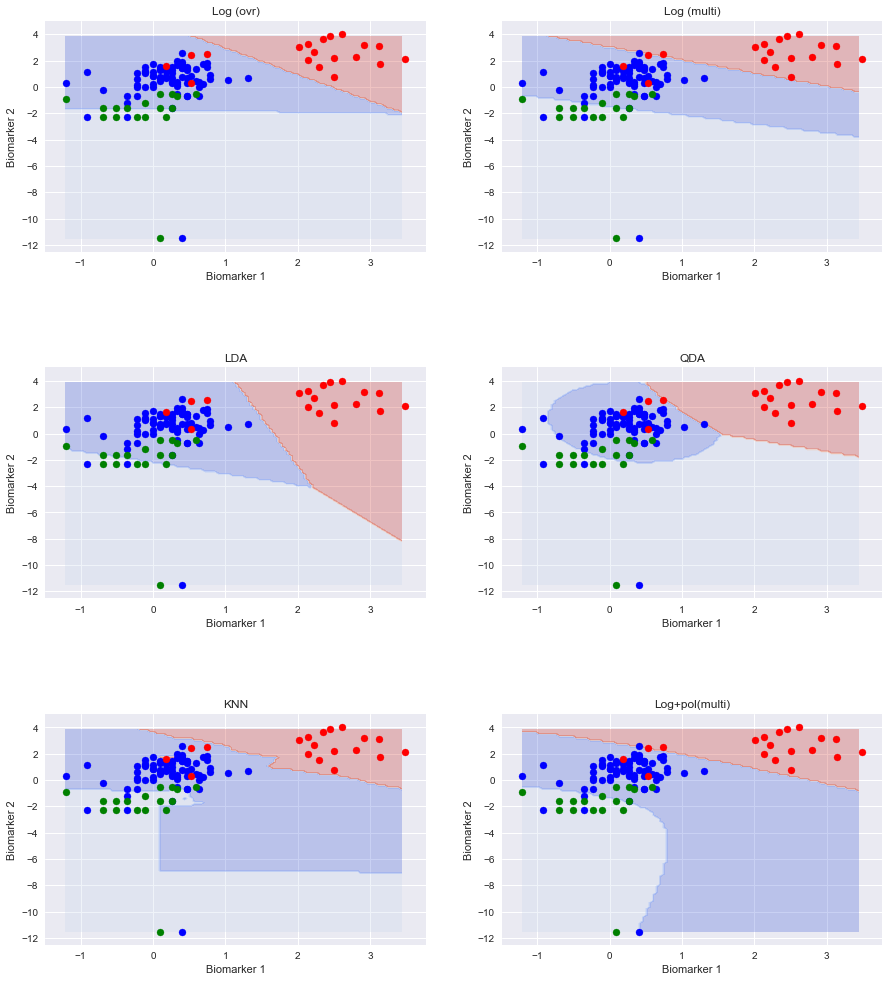

In [14]:
fig,ax = plt.subplots(3,2,figsize=(15,17))
plot_decision_boundary(X_test.as_matrix(),y_test.values,lrcv_ovr,'Log (ovr)',ax[0,0])
plot_decision_boundary(X_test.as_matrix(),y_test.values,lrcv_multi,'Log (multi)',ax[0,1])
plot_decision_boundary(X_test.as_matrix(),y_test.values,svd,'LDA',ax[1,0])
plot_decision_boundary(X_test.as_matrix(),y_test.values,qda,'QDA',ax[1,1])
plot_decision_boundary(X_test.as_matrix(),y_test.values,knn,'KNN',ax[2,0])
plot_decision_boundary(xtst,y_test.values,lrcv_pol,'Log+pol(multi)', ax[2,1],poly_degree =2)
fig.subplots_adjust(hspace=.5)

** Question -
Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
**

- **Linear OvR vs Multinomial**: With ovr the boundaries have a similar bias point while with multinomial they are separated. This is an artifact of the way in which the two models work. Remember that multinomial will compare one class against each other class from a reference so this is likely to create much wider bands since this classification depends on the separate classes. On the other hand, OvR does one class against all other classes lumped together.
- ** Linear Log vs LDA**: LDA uses 3 lines instead of 2 for the boundary and predicts that 'normal' people will remain in the upper left of biomarker 2 while red will see more vertical variance. In many ways the mapping of the boundary seems to depend on the variance of the datapoints within each diagnosis. This makes sense to some degree since LDA uses single value decomposition is linked to PCA (not going into the math here) and we can recall that PCA measures the variance within the features.
- ** Quadratic Log (multi) vs QDA**: QDA has a decision boundary wrapped tightly around the 'normal' class while QDA has quadratic curves about the 'normal' class. This difference is due to the fact that QDA measures the mean of each of the classes and makes elliptical boundaries about the data points and finds where they intersect other boundaries for other classes. In Quadratic Logistic regression we really are trying to find the non linear relationship between the markers to classify these regions with no intrinsic assumption about the distribution of classes.

## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

In [15]:
cvsc = []
for i in range(2,11):
    tree = DecisionTreeClassifier(criterion='gini',max_depth = i)
    tree.fit(X_train,y_train)
    cvsc.append((tree.score(X_train,y_train),tree.score(X_test,y_test)))

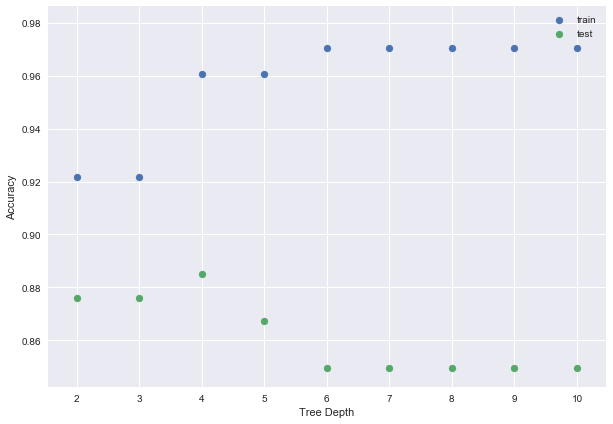

In [16]:
cvsc = np.array(cvsc)
treelen = np.arange(2,11,1)
plt.figure(figsize=(10,7))
plt.scatter(treelen,cvsc[:,0],label = 'train')
plt.scatter(treelen,cvsc[:,1],label = 'test')
plt.legend()
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')

In [17]:
scores = []
for i in range(2,11):
    tree = DecisionTreeClassifier(criterion='gini',max_depth = i)
    scores.append(cross_val_score(tree,X_train,y_train,cv=5))
scores = np.array(scores)
means = np.mean(scores,axis=1)
stds = np.std(scores,axis=1)

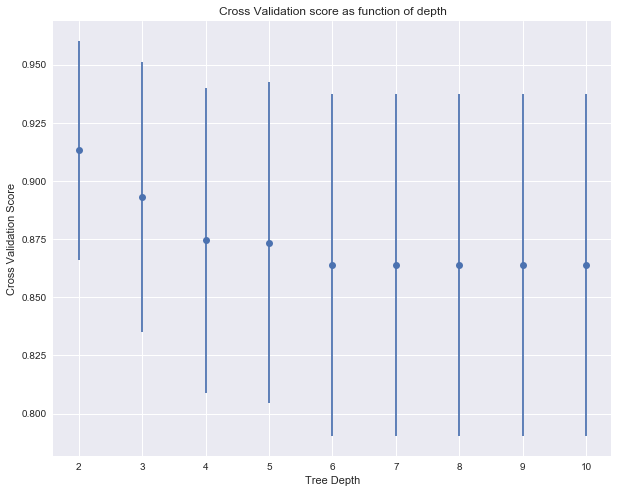

In [18]:
plt.figure(figsize=(10,8))
plt.errorbar(treelen,means,yerr=stds,fmt='o')
plt.title('Cross Validation score as function of depth')
plt.xlabel('Tree Depth')
plt.ylabel('Cross Validation Score')

In [19]:
tree = DecisionTreeClassifier(criterion='gini',max_depth = 2)
tree.fit(X_train,y_train)
print('The training accuracy(Tree)= %s' %tree.score(X_train,y_train))
print('The test accuracy(Tree)= %s' %tree.score(X_test,y_test))
trdf = pd.DataFrame([tree.score(X_train,y_train),tree.score(X_test,y_test)])
trdf = trdf.set_index(dfmix.index)
dfmix['tree'] = trdf

The training accuracy(Tree)= 0.921568627451
The test accuracy(Tree)= 0.87610619469


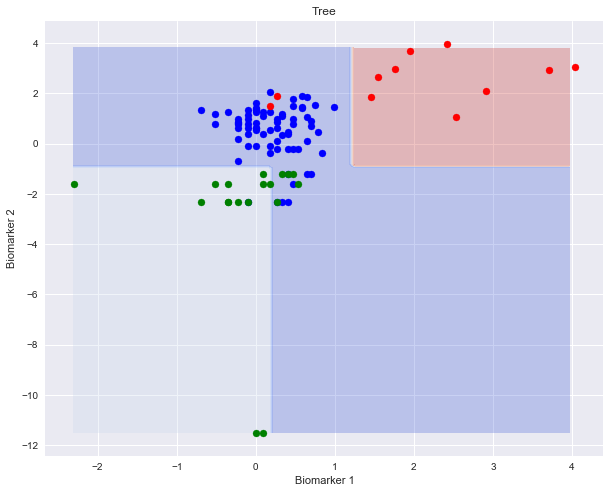

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
plot_decision_boundary(X_train.as_matrix(),y_train.values,tree,'Tree',ax)

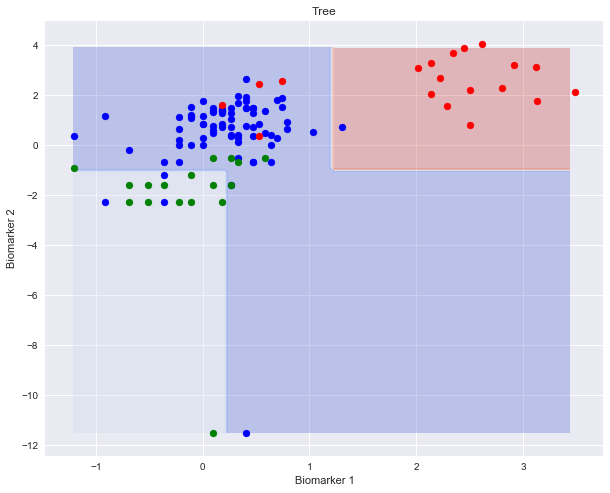

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
plot_decision_boundary(X_test.as_matrix(),y_test.values,tree,'Tree',ax)

In [22]:
from graphviz import Source
import pydotplus
import graphviz
export_graphviz(tree,out_file='tree.dot')

In [23]:
graph = pydotplus.graphviz.graph_from_dot_file('tree.dot')

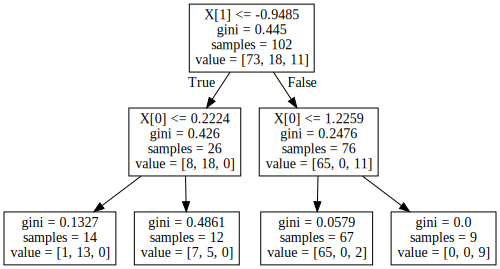

In [24]:
# getting this to work on windows was a pai
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Your Answer Here

** Question - Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?**

- The deeper the tree, the more leaf nodes and the more over-fitting. We could even imagine going down and having a box around each datapoint and classifying it this way. In comparison to our other models, by the 6'th depth we reach near perfect accuracy in the training set. Such high level of accuracy in the training could mean over-fitting and could also hurt our test performance - hence the next question!

** Question - Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?**

- Using 5 fold cross validation on the different tree depths suggests (as in the figure I plotted above) that max depth should be set to 2 since this provides the highest mean and the variance at that depth is comparable to the variance at other depths. We note a relatively high training performance of 0.921 but 0.876 in the test set which is comparable to a linear logistic OvR model so we are not really improving our accuracy in using this model.

** Question - Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.**

- Decision boundary of the tree has sharp horizontal and vertical lines unlike the other models. We also find that it considers 'normal' class as expanding down to the bottom right in a similar way that logistic with polynomial features does. As Pavlos explained in class, the decision boundary for a tree is literally one where a threshold is chosen on the y axis and one which is chosen on the x. By this simple analysis we can say that we should get boundaries that are vertical and horizontal intersecting.

** Question - Use the export_graphviz function in sklearn to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain in words how the fitted model diagnoses 'hypothyroidism' for a patient.**

- Hypothyroidism is class 3 (red dots) 
- Step 1: Checks to see if the data point is below -0.9 in biomarker 2 which for hypothyroidism is False (from training)
- Step 2: so go down the right node, check if biomarker 1 level is below 1.22 which for hypothyroidism is generally False(trainig)
- Step 3: if its false in step 1 and 2, classify patient as having hypothyroidism!

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

In [25]:
dfmix.loc[len(dfmix)] = ['linear','linear','non linear','non linear','non linear',' non linear','non linear']
dfmix.loc[len(dfmix)] = ['p','p','p','p','np','p','np']
dfmix.loc[len(dfmix)] = [1,2,3,6,7,4,5]
dfmix.loc[len(dfmix)] = [2,2,4,5,2,3,1]
dfmix.index =['Training Accuracy:','Testing Accuracy:','Complexity(Boundary)', 'parametric',   'Memory','Interpretability']


In [26]:
dfmix

,Log (OvR),Log (Multi),LDA,QDA,KNN,Log+pol(multi),tree
Training Accuracy:,0.843137,0.892157,0.872549,0.872549,0.931373,0.892157,0.921569
Testing Accuracy:,0.840708,0.884956,0.831858,0.849558,0.867257,0.893805,0.876106
Complexity(Boundary),linear,linear,non linear,non linear,non linear,non linear,non linear
parametric,p,p,p,p,np,p,np
Memory,1,2,3,6,7,4,5
Interpretability,2,2,4,5,2,3,1


- Training and Test accuracy are self explanatory and have been discussed extensively in a previous section
- Complexity of the boundary depends on the model, with non linear models being more complex than linear boundaries. Tree models are technically non linear since the decision boundaries are not well defined by a simple equation (rather they have sharp edges so happen to be the sum of many sines and cosines). LDA,QDA and Logistic regression are inherently parametric. Non parametric are KNN, decision trees and SVM(if we had it!).
- Memory is somewhat correlated to complexity of the boundary. The decision boundary of knn is complex(non-linear) and non parametric so we expect it to store a lot of memory since the number of parameters changes with more training data. Trees are slightly less complex (boundaries are lines) but they are also non parametric so they come second. LDA QDA and logistic with polynomial terms are all parametric but complex, with QDA consuming more memory due to different correlation values. Since LDA stores the single value decomposition and these are matrices, we expect this to store more data. Lastly, we are left with parametric linear models of OvR and multinomial. Since multinomial stores 1 less set of coefficients it consumes the least memory.
- Interpretability of the models depends on a case by case basis. For classification, it seems as though trees are highly interpretable since we can think of the decision making process as going down and across a tree by checking different conditions. The next would be knn or linear logistic regression since these can be explained without having to talk about non linearities. The next level would be quadratic logistic regression and the final would be LDA then QDA. The last two are hard to interpret because they make assumptions about the distributions of the datasets and include some complicated underpinnings such as SVD.

** Question - If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using?**

- As a clinician it is in your best interest to use a model that performs relatively well and produces a high level of accuracy. By this token they should use logistic regression with polynomial terms. However, this is only a first level of analysis. Some clinicians might worry that if they misdiagnose someone using the model then that individual could file for damages and in a court of law, explaining logistic regression with polynomial features may lose a case. Interpretability becomes a huge issue here as Professor Finale Doshi-Velez explained in a talk last Friday. Being able to use a model that shows the 'decision' making process helps humans understand the blackbox rather than use it without knowing its internal dynamics. With this, using a model such as the decision tree would be great since you explain how the model came up with a solution.


## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.

### Your Answer Here

There appeared to be 2 immediate ways I could think of solving this problem. One way is to simply create a top threshold and ask, if the max probability of the three is lower than this threshold then abstain. This model will simply say if I am not confident of the highest probability reflecting that class then i should abstain.

Another alternative, is to create a top and bottom boundary. The aim of this is to look at each class and say, how confident are we about our classification. If any one of the 3 probabilities falls into the bounds of say (0.4,0.6) then abstain. That way we can capture abstains by seeing whether we are uncertain about any one of the three probabilities.

In this example, a choice between the two makes no difference to the optimization. Therefore, I choose to implement both and use the single bound version to explain to a clinician.

### Top and Bottom Bound Approach

In [49]:
probs = lrcv_ovr.predict_proba(X_test)
ypred = lrcv_ovr.predict(X_test)

In [50]:
print('Total # of misclassifications OvR logistic (linear) = %s' %(np.shape(np.nonzero(ypred-y_test))[1]))
print('Total cost of OvR logistic (linear) = $%s' %(5000*np.shape(np.nonzero(ypred-y_test))[1]))
print('Avg cost/patient of OvR logistic (linear) = $%s' %(90000/len(ypred)))

Total # of misclassifications OvR logistic (linear) = 18
Total cost of OvR logistic (linear) = $90000
Avg cost/patient of OvR logistic (linear) = $796.4601769911504


### 1-D optimisation

In [51]:
storemain = []
type1 = []
thresh = np.linspace(0.3,1,1000)

for j in range(len(thresh)):
    ert = thresh[j]
    erb = 1-thresh[j]
    idxabstain = np.nonzero(np.sum((probs>erb)&(probs<ert),axis=1))
    Nabs = np.shape(idxabstain)[1]
    tempypred = np.delete(ypred,idxabstain)
    tempyact = np.delete(y_test.values,idxabstain)
    Mabs = np.shape(np.nonzero(tempypred-tempyact))[1]
    storemain.append((Nabs,Mabs))

    

In [52]:
storemain = np.array(storemain)

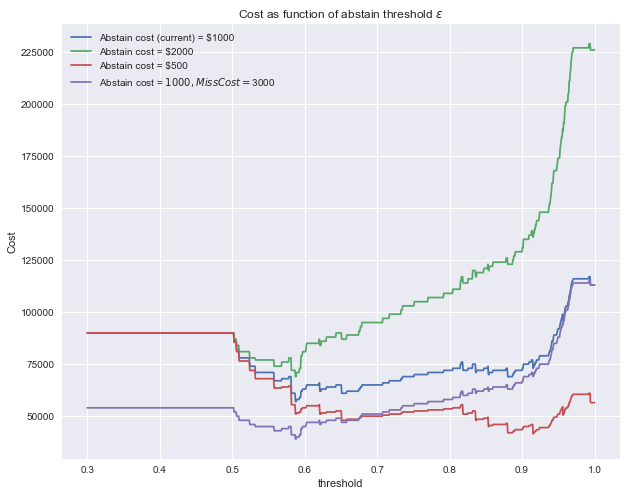

In [53]:
plt.figure(figsize=(10,8))
plt.title('Cost as function of abstain threshold $\epsilon $')
plt.plot(thresh, 1000*storemain[:,0] + 5000*storemain[:,1],label='Abstain cost (current) = $1000')
plt.plot(thresh, 2000*storemain[:,0] + 5000*storemain[:,1],label='Abstain cost = $2000')
plt.plot(thresh, 500*storemain[:,0] + 5000*storemain[:,1],label='Abstain cost = $500')
plt.plot(thresh, 1000*storemain[:,0] + 3000*storemain[:,1],label='Abstain cost = $1000, Miss Cost = $3000')

plt.legend()
plt.xlabel('threshold')
plt.ylabel('Cost')

In [54]:
idx = np.argmin(1000*storemain[:,0]+5000*storemain[:,1])
print('Abstain = %s' %(storemain[idx,0]))
print('Misclassified = %s' %(storemain[idx,1]))
print('Best parameter = %s' %(thresh[idx]-0.5))
print('Min Total Cost = $%s' %(min(1000*storemain[:,0]+5000*storemain[:,1])))
print('Min Total Cost/person = $%s' %(58000/113))


Abstain = 12
Misclassified = 9
Best parameter = 0.0872872872873
Min Total Cost = $57000
Min Total Cost/person = $513.2743362831858


### 2-D Optimisation

In [55]:
storemain = []
type1 = []
thresht = np.linspace(0.5,0.99,100)
threshb = np.linspace(0,0.5,100)

for j in range(len(thresht)):
    ert = thresht[j]
    for k in range(len(threshb)):
        erb = threshb[k]
        idxabstain = np.nonzero(np.sum((probs>erb)&(probs<ert),axis=1))
        Nabs = np.shape(idxabstain)[1]
        tempypred = np.delete(ypred,idxabstain)
        tempyact = np.delete(y_test.values,idxabstain)
        Mabs = np.shape(np.nonzero(tempypred-tempyact))[1]
        storemain.append((j,k,Nabs,Mabs))

    

In [56]:
storemain = np.array(storemain)


In [57]:
x = thresht
y= threshb
X,Y = np.meshgrid(x,y)
Z = 1000*storemain[:,2] + 5000*storemain[:,3]
Z=Z.reshape(X.shape)

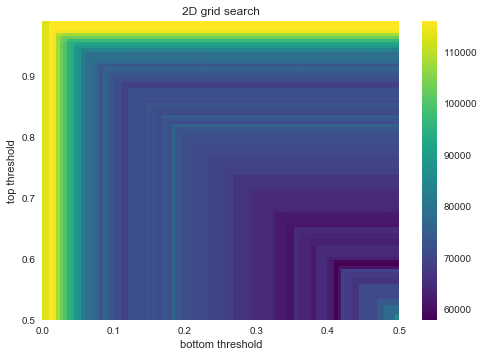

In [58]:
plt.pcolor(Y,X,Z.T,cmap='viridis')
plt.colorbar()
plt.xlabel('bottom threshold')
plt.ylabel('top threshold')
plt.title('2D grid search')

In [59]:
ztest = 1000*storemain[:,2] + 5000*storemain[:,3]

In [60]:
print('Abstain = %s' %(storemain[2290,2]))
print('Misclassified = %s' %(storemain[2290,3]))
print('One best parameter top limiter = %s' %(thresht[0]))
print('One best parameter bottom limiter = %s' %(threshb[77]))
print('Min Total Cost = $%s' %(min(ztest)))
print('Min Total Cost/person = $%s' %(min(ztest)/113))


Abstain = 20
Misclassified = 9
One best parameter top limiter = 0.5
One best parameter bottom limiter = 0.388888888889
Min Total Cost = $58000
Min Total Cost/person = $513.274336283


### One bound approach

In [61]:
storemain = []
type1 = []
thresh = np.linspace(0.3,1,1000)

for j in range(len(thresh)):
    ert = thresh[j]
    zz = np.amax(probs,axis=1)
    tf = zz<ert
    idxabstain  = np.nonzero(tf)
    #idxabstain = np.nonzero(np.sum((probs>erb)&(probs<ert),axis=1))
    Nabs = np.shape(idxabstain)[1]
    tempypred = np.delete(ypred,idxabstain)
    tempyact = np.delete(y_test.values,idxabstain)
    Mabs = np.shape(np.nonzero(tempypred-tempyact))[1]
    storemain.append((Nabs,Mabs))

    

In [62]:
storemain = np.array(storemain)

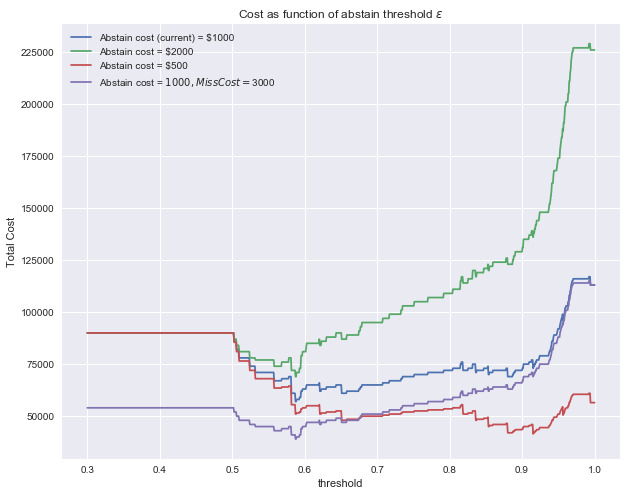

In [63]:
plt.figure(figsize=(10,8))
plt.title('Cost as function of abstain threshold $\epsilon $')
plt.plot(thresh, 1000*storemain[:,0] + 5000*storemain[:,1],label='Abstain cost (current) = $1000')
plt.plot(thresh, 2000*storemain[:,0] + 5000*storemain[:,1],label='Abstain cost = $2000')
plt.plot(thresh, 500*storemain[:,0] + 5000*storemain[:,1],label='Abstain cost = $500')
plt.plot(thresh, 1000*storemain[:,0] + 3000*storemain[:,1],label='Abstain cost = $1000, Miss Cost = $3000')

plt.legend()
plt.xlabel('threshold')
plt.ylabel('Total Cost')

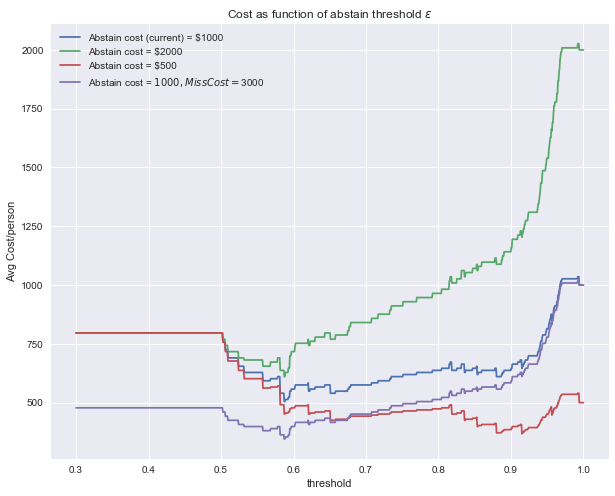

In [64]:
plt.figure(figsize=(10,8))
plt.title('Cost as function of abstain threshold $\epsilon $')
plt.plot(thresh, (1000*storemain[:,0] + 5000*storemain[:,1])/113,label='Abstain cost (current) = $1000')
plt.plot(thresh, (2000*storemain[:,0] + 5000*storemain[:,1])/113,label='Abstain cost = $2000')
plt.plot(thresh, (500*storemain[:,0] + 5000*storemain[:,1])/113,label='Abstain cost = $500')
plt.plot(thresh, (1000*storemain[:,0] + 3000*storemain[:,1])/113,label='Abstain cost = $1000, Miss Cost = $3000')

plt.legend()
plt.xlabel('threshold')
plt.ylabel('Avg Cost/person')

In [65]:
idx = np.argmin(1000*storemain[:,0]+5000*storemain[:,1])
print('Abstain = %s' %(storemain[idx,0]))
print('Misclassified = %s' %(storemain[idx,1]))
print('Best parameter = %s' %(thresh[idx]-0.5))
print('Min Total Cost = $%s' %(min(1000*storemain[:,0]+5000*storemain[:,1])))
print('Min Avg Cost/ Person = $%s' %(min(1000*storemain[:,0]+5000*storemain[:,1])/113))


Abstain = 12
Misclassified = 9
Best parameter = 0.0872872872873
Min Total Cost = $57000
Min Avg Cost/ Person = $504.424778761


### filler for print